In [1]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import csv
import random
from PIL import Image

import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D

import MusicGenreClassificationTool as mgc

## Data preparation

In [2]:
mgc.extractFeaturesToCSV()

C:\Users\Wojtek\anaconda3\envs\music-genre-classification\lib\site-packages\librosa\core\pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [2]:
mgc.saveSpectrogramsToPNG()

C:\Users\Wojtek\anaconda3\envs\music-genre-classification\lib\site-packages\matplotlib\image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
C:\Users\Wojtek\anaconda3\envs\music-genre-classification\lib\site-packages\matplotlib\image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
C:\Users\Wojtek\anaconda3\envs\music-genre-classification\lib\site-packages\matplotlib\image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
C:\Users\Wojtek\anaconda3\envs\music-genre-classification\lib\site-packages\matplotlib\image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)


<Figure size 432x288 with 0 Axes>

In [ ]:
mgc.saveSpectrogramsToNPZ()

Currently processing:  100  in Electronic
Currently processing:  200  in Electronic
Currently processing:  300  in Electronic
Currently processing:  400  in Electronic
Couldn't process:  485


## Spectrograms (image)

In [2]:
image_size = tuple((224, 224))

samples, labels = mgc.loadImages('img_data', image_size)

loaded 7997  samples
classes {'Experimental', 'Hip-Hop', 'International', 'Instrumental', 'Rock', 'Electronic', 'Folk', 'Pop'}
Labels shape (7997, 8)


In [3]:
dict_genres = mgc.makeDictionary()

reverse_map = {v: k for k, v in dict_genres.items()}

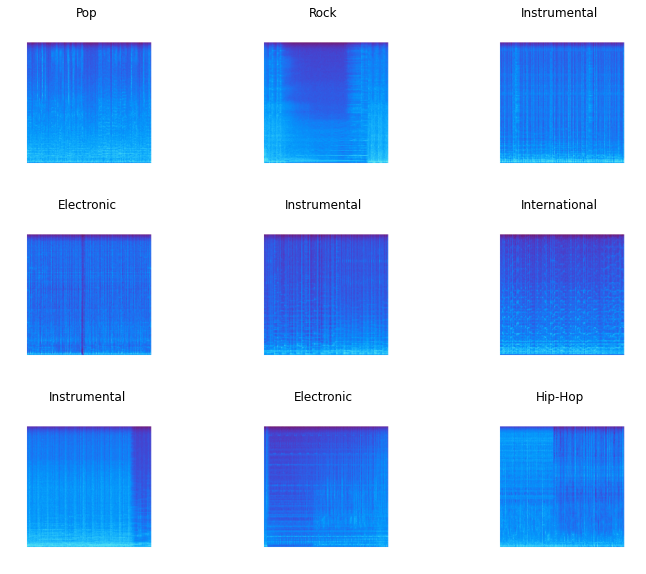

In [4]:
plt.figure(figsize=(12, 10))
for i in range(9):
    n = random.randrange(len(samples))
    plt.subplot(3, 3, i + 1)
    plt.imshow(samples[n])
    genre = np.argmax(labels[n])
    plt.title(reverse_map[genre])
    plt.axis("off")

In [6]:
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

input_shape = samples[0].shape

model = Sequential()
model.add(Conv2D(16, (3, 3), padding="same",input_shape=input_shape))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
#model.add(Dense(64))
#model.add(Activation("relu"))
model.add(Dense(8))
model.add(Activation("softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
activation (Activation)      (None, 224, 224, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
activation_1 (Activation)    (None, 112, 112, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0

In [7]:
import sklearn.model_selection

(trainSamples, testSamples, trainLabels, testLabels) = sklearn.model_selection.train_test_split(samples,labels,random_state=42,stratify=labels, test_size=0.5)
optimizer = tf.keras.optimizers.RMSprop(0.0001, decay = 1e-6)
model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])

In [8]:
history = model.fit(trainSamples, trainLabels, batch_size=64, epochs=20, validation_data=(testSamples,testLabels))  

Train on 3998 samples, validate on 3999 samples
Epoch 1/20
3998/3998 [==============================] - 57s 14ms/sample - loss: 198.5843 - accuracy: 0.1358 - val_loss: 71.7798 - val_accuracy: 0.1355
Epoch 2/20
3998/3998 [==============================] - 60s 15ms/sample - loss: 38.2489 - accuracy: 0.1581 - val_loss: 9.8331 - val_accuracy: 0.2231
Epoch 3/20
3998/3998 [==============================] - 59s 15ms/sample - loss: 6.1797 - accuracy: 0.1868 - val_loss: 4.1934 - val_accuracy: 0.1305
Epoch 4/20
3998/3998 [==============================] - 60s 15ms/sample - loss: 2.5967 - accuracy: 0.2191 - val_loss: 2.6203 - val_accuracy: 0.2723
Epoch 5/20
3998/3998 [==============================] - 60s 15ms/sample - loss: 2.0091 - accuracy: 0.2766 - val_loss: 2.1194 - val_accuracy: 0.2516
Epoch 6/20
3998/3998 [==============================] - 58s 14ms/sample - loss: 1.7461 - accuracy: 0.3547 - val_loss: 2.0161 - val_accuracy: 0.2961
Epoch 7/20
3998/3998 [==============================] - 61s 

In [10]:
predicted = model.predict(testSamples)

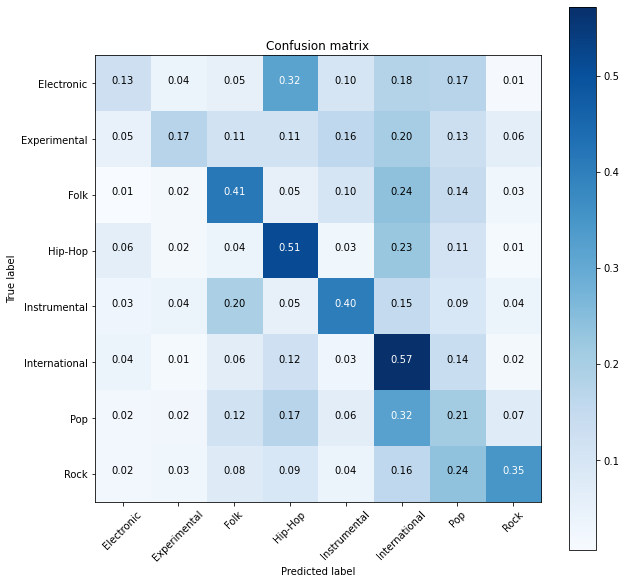

In [11]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(testLabels.argmax(axis=1), predicted.argmax(axis=1))

plt.figure(figsize=(10,10))
mgc.plotConfusionMatrix(cm, dict_genres, normalize=True)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


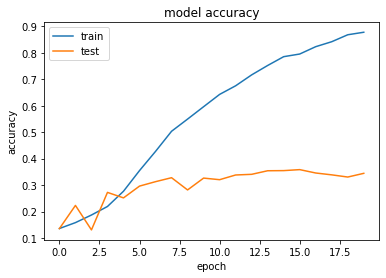

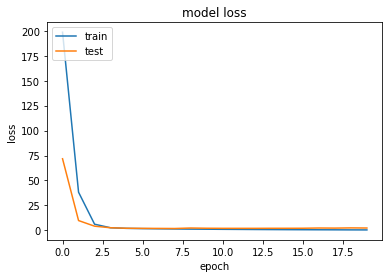

In [12]:
mgc.showSummaryStats(history)

## Spectrograms (array)

In [2]:
samples, labels = mgc.loadArrays('data_arr.npz')

['arr_0', 'arr_1']
(7994, 640, 128) (7994, 8)


In [3]:
dict_genres = mgc.makeDictionary()

reverse_map = {v: k for k, v in dict_genres.items()}

Electronic


C:\Users\Wojtek\anaconda3\envs\music-genre-classification\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\Wojtek\anaconda3\envs\music-genre-classification\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


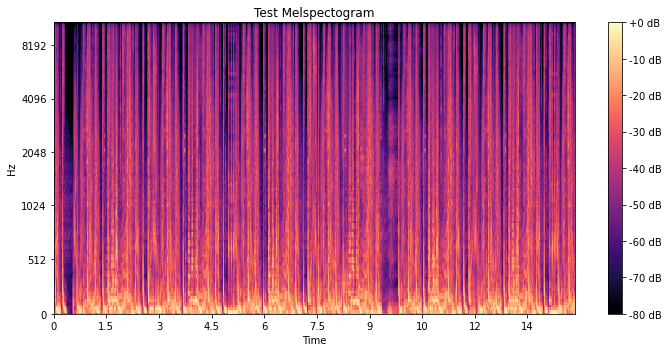

In [4]:
num = 11
spectogram = samples[num]
genre = np.argmax(labels[num])
print(reverse_map[genre])
plt.figure(figsize=(10, 5))
librosa.display.specshow(spectogram.T, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Test Melspectogram')
plt.tight_layout()

In [5]:
samples = np.expand_dims(samples, axis=3)
print(samples.shape, labels.shape)

(7994, 640, 128, 1) (7994, 8)


In [9]:
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

input_shape = samples[0].shape

model = Sequential()
model.add(Conv2D(16, (3, 3), padding="same",input_shape=input_shape))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
#model.add(Dense(64))
#model.add(Activation("relu"))
model.add(Dense(8))
model.add(Activation("softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 640, 128, 16)      160       
_________________________________________________________________
activation (Activation)      (None, 640, 128, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 320, 64, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 320, 64, 32)       4640      
_________________________________________________________________
activation_1 (Activation)    (None, 320, 64, 32)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 160, 32, 32)       0         
_________________________________________________________________
flatten (Flatten)            (None, 163840)            0

In [10]:
(trainSamples, testSamples, trainLabels, testLabels) = sklearn.model_selection.train_test_split(samples,labels,random_state=42,stratify=labels, test_size=0.5)
optimizer = tf.keras.optimizers.RMSprop(0.0001, decay = 1e-6)
model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])

In [11]:
history = model.fit(trainSamples, trainLabels, batch_size=64, epochs=10, validation_data=(testSamples,testLabels)) 

Train on 3997 samples, validate on 3997 samples
Epoch 1/10
3997/3997 [==============================] - 83s 21ms/sample - loss: 42.9913 - accuracy: 0.1406 - val_loss: 15.6996 - val_accuracy: 0.1981
Epoch 2/10
3997/3997 [==============================] - 83s 21ms/sample - loss: 12.7221 - accuracy: 0.1936 - val_loss: 7.0616 - val_accuracy: 0.2007
Epoch 3/10
3997/3997 [==============================] - 82s 20ms/sample - loss: 4.3714 - accuracy: 0.2987 - val_loss: 2.6509 - val_accuracy: 0.3445
Epoch 4/10
3997/3997 [==============================] - 84s 21ms/sample - loss: 1.9481 - accuracy: 0.4201 - val_loss: 2.1031 - val_accuracy: 0.3858
Epoch 5/10
3997/3997 [==============================] - 87s 22ms/sample - loss: 1.2001 - accuracy: 0.5899 - val_loss: 1.8216 - val_accuracy: 0.3523
Epoch 6/10
3997/3997 [==============================] - 86s 22ms/sample - loss: 0.7976 - accuracy: 0.7328 - val_loss: 1.9360 - val_accuracy: 0.3883
Epoch 7/10
3997/3997 [==============================] - 84s 2

In [12]:
predicted = model.predict(testSamples)

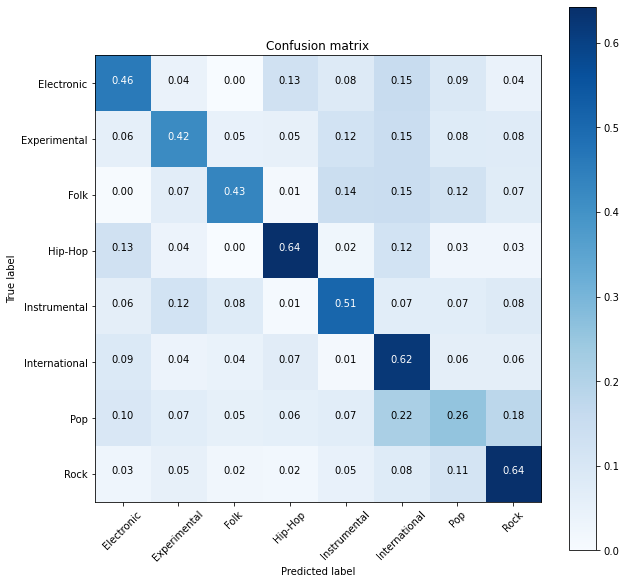

In [21]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(testLabels.argmax(axis=1), predicted.argmax(axis=1))

plt.figure(figsize=(10,10))
mgc.plotConfusionMatrix(cm, dict_genres, normalize=True)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


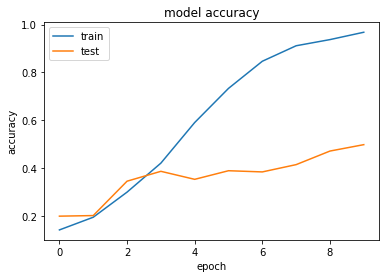

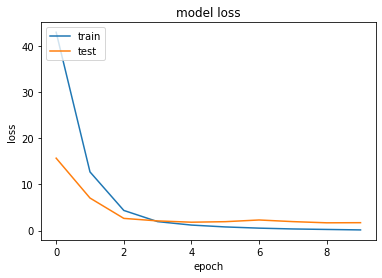

In [22]:
mgc.showSummaryStats(history)

## Spectrogram (features)

In [2]:
samples, labels = mgc.loadFeatures('features.csv')

In [6]:
trainSamples, testSamples, trainLabels, testLabels = train_test_split(samples, labels, test_size=0.1)

In [7]:
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(trainSamples.shape[1],)))

model.add(Dense(128, activation='relu'))

model.add(Dense(64, activation='relu'))

model.add(Dense(8, activation='softmax'))

In [8]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [9]:
history = model.fit(trainSamples, trainLabels, epochs=100, batch_size=128, validation_data=(testSamples,testLabels))

Train on 7197 samples, validate on 800 samples
Epoch 1/100
7197/7197 [==============================] - 1s 80us/sample - loss: 1.7972 - accuracy: 0.3369 - val_loss: 1.6862 - val_accuracy: 0.3837
Epoch 2/100
7197/7197 [==============================] - 0s 13us/sample - loss: 1.6194 - accuracy: 0.4129 - val_loss: 1.6019 - val_accuracy: 0.4238
Epoch 3/100
7197/7197 [==============================] - 0s 12us/sample - loss: 1.5475 - accuracy: 0.4375 - val_loss: 1.5898 - val_accuracy: 0.4300
Epoch 4/100
7197/7197 [==============================] - 0s 11us/sample - loss: 1.5013 - accuracy: 0.4595 - val_loss: 1.5775 - val_accuracy: 0.4313
Epoch 5/100
7197/7197 [==============================] - 0s 12us/sample - loss: 1.4651 - accuracy: 0.4752 - val_loss: 1.5618 - val_accuracy: 0.4288
Epoch 6/100
7197/7197 [==============================] - 0s 12us/sample - loss: 1.4256 - accuracy: 0.4906 - val_loss: 1.5510 - val_accuracy: 0.4400
Epoch 7/100
7197/7197 [==============================] - 0s 12us/

In [10]:
predicted = model.predict(testSamples)

In [11]:
dict_genres = mgc.makeDictionary()

reverse_map = {v: k for k, v in dict_genres.items()}

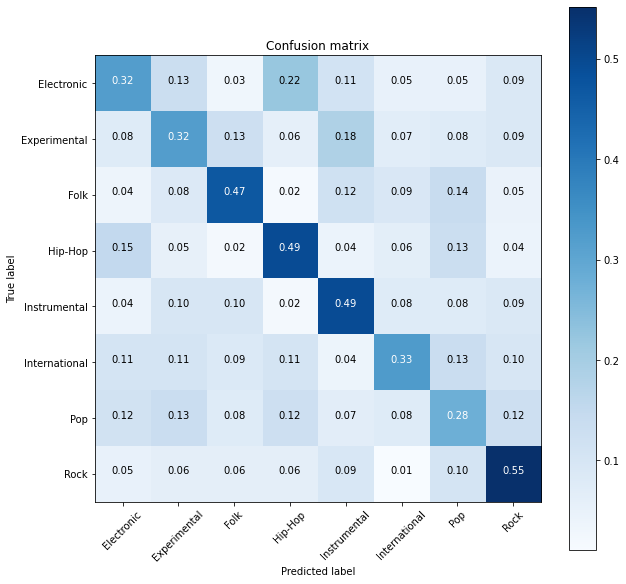

In [12]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(testLabels, predicted.argmax(axis=1))

plt.figure(figsize=(10,10))
mgc.plotConfusionMatrix(cm, dict_genres, normalize=True)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


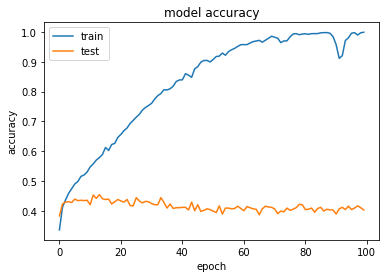

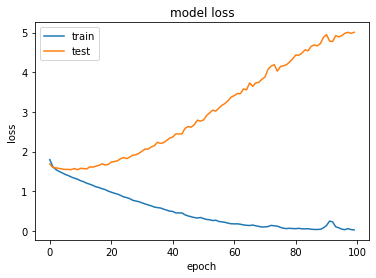

In [13]:
mgc.showSummaryStats(history)